In [ ]:
#importing packages
%matplotlib inline
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
plt.style.use('ggplot')

In [ ]:
#1- Import Data
#Original Dataset from Kaggle https://www.kaggle.com/mlg-ulb/creditcardfraud

#import from google drive
datapart1 = pd.read_csv("https://docs.google.com/uc?id=1au1K51mF2FfhdRVGYtKEMs-RJyiPeyTC&export=download")
datapart2 = pd.read_csv("https://docs.google.com/uc?id=1GabYXZ9Brd8wJXY2UIXBgjEWzfh7kyKB&export=download")
frames = [datapart1, datapart2]

data= pd.concat(frames)
data.reset_index(drop=True, inplace=True)
#check the dataset
data.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [ ]:
# Due to confidentiality, contains only numerical variables resulting of a PCA transformation. You could check the original dataset description on Kaggle for the details

(array([10510., 16955., 38526., 38550., 40243., 10145., 17161., 38951.,
        40779., 32987.]),
 array([     0. ,  17279.2,  34558.4,  51837.6,  69116.8,  86396. ,
        103675.2, 120954.4, 138233.6, 155512.8, 172792. ]),
 <a list of 10 Patch objects>)

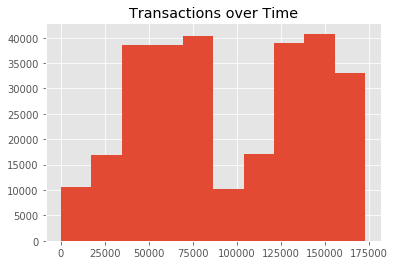

In [ ]:
#2- Explore Data
#visualizations of time and amount
plt.title('Transactions over Time')
plt.hist(data.Time)

(array([2.84395e+05, 3.60000e+02, 3.60000e+01, 1.00000e+01, 2.00000e+00,
        1.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([    0.   ,  2569.116,  5138.232,  7707.348, 10276.464, 12845.58 ,
        15414.696, 17983.812, 20552.928, 23122.044, 25691.16 ]),
 <a list of 10 Patch objects>)

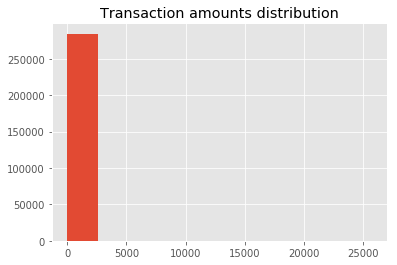

In [ ]:
#Amounts visualization
plt.title('Transaction amounts distribution')
plt.hist(data.Amount)
# the mean amount is around $90 and the maximum transaction is aroung $25,000

In [ ]:
#fraud vs. legit transactions count
count = data.Class.value_counts()
legit = count[0]
fraud = count[1]
legit_pct = (legit/(legit+fraud))*100
fraud_pct = (fraud/(legit+fraud))*100
print('   {:.3f}% legit transactions, total count of {} vs {:.3f}% fraud transactions , total count of {}.'.format(legit_pct,legit, fraud_pct,fraud))

   99.827% legit transactions, total count of 284315 vs 0.173% fraud transactions , total count of 492.


Text(0.5, 0, '0:Legit transactions  vs  1:Fraudulent transactions')

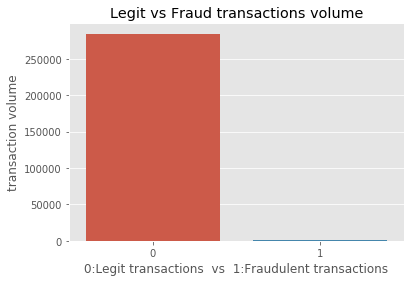

In [ ]:
#fraud vs. normal transactions visualization
sns.barplot(x=count.index, y=count)
plt.title('Legit vs Fraud transactions volume')
plt.ylabel('transaction volume')
plt.xlabel('0:Legit transactions  vs  1:Fraudulent transactions')

#There is very few fraud transactions but lots of legit ones, we should take care of this Underbalanced class representation
#following recos published: https://www.researchgate.net/publication/283349138_Calibrating_Probability_with_Undersampling_for_Unbalanced_Classification

Text(0.5, 1.0, 'Correlogram')

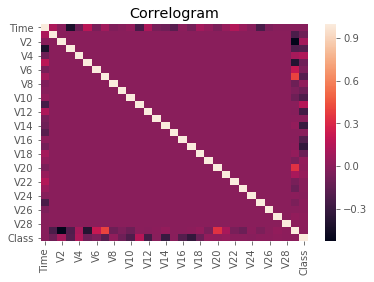

In [ ]:
#Check if there is any dependencies between the diffrent variables, if so we can combine them
corr = data.corr()
heat = sns.heatmap(data=corr)
plt.title('Correlogram')

In [ ]:
# Check if there is any asymetric variable, if so we can scale them
asymetry = data.skew()
asymetry

Time      -0.035568
V1        -3.280667
V2        -4.624866
V3        -2.240155
V4         0.676292
V5        -2.425901
V6         1.826581
V7         2.553907
V8        -8.521944
V9         0.554680
V10        1.187141
V11        0.356506
V12       -2.278401
V13        0.065233
V14       -1.995176
V15       -0.308423
V16       -1.100966
V17       -3.844914
V18       -0.259880
V19        0.109192
V20       -2.037155
V21        3.592991
V22       -0.213258
V23       -5.875140
V24       -0.552499
V25       -0.415793
V26        0.576693
V27       -1.170209
V28       11.192091
Amount    16.977724
Class     23.997579
dtype: float64

In [ ]:
#3- Prepare data

#Scaling Time and Amount, to have the mean 0 and Std Deviation 1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#scaling time
scaled_time = scaler.fit_transform(data[['Time']])
flat_list1 = [item for sublist in scaled_time.tolist() for item in sublist]
scaled_time = pd.Series(flat_list1)

scaler2 = StandardScaler()
#scaling the amount column
scaled_amount = scaler2.fit_transform(data[['Amount']])
flat_list2 = [item for sublist in scaled_amount.tolist() for item in sublist]
scaled_amount = pd.Series(flat_list2)

In [ ]:
#Reseting Index as we randomly took transactions they came with their indexes from first dataset
scaled_amount.reset_index(drop=True, inplace=True)
scaled_time.reset_index(drop=True, inplace=True)

#Substitute time and amount by scaled time and amount
data = pd.concat([data, scaled_amount.rename('scaled_amount'), scaled_time.rename('scaled_time')], axis=1)

#dropping old amount and time columns
data.drop(['Amount', 'Time'], axis=1, inplace=True)

data.head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562


In [ ]:
# Split the dataset in Training 70%  and Testing datasets
mask = np.random.rand(len(data)) < 0.90
train = data[mask]
test = data[~mask]

#Reseting Index as we randomly took transactions they came with their indexes from first dataset
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [ ]:
#how many random samples from normal transactions do we need?
trainingFraudulentCount = train.Class.value_counts()[1]
print('There are {} fraudulent transactions in the train data.'.format(trainingFraudulentCount))

There are 441 fraudulent transactions in the train data.


In [ ]:
#Select randomly same volume of legit transactions
trainLegit = train[train['Class'] == 0]
trainFraud = train[train['Class'] == 1]

In [ ]:
filteredTrainLegit = trainLegit.sample(trainingFraudulentCount)
filteredTrainLegit.head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
107489,1.126376,-1.098248,-0.577764,-0.759379,-0.332117,0.416791,-0.313358,0.087788,-0.833831,0.715774,-0.045756,-0.217078,-0.811822,0.423736,-0.270204,-1.483939,-0.015519,1.183741,-0.130604,-0.264191,-0.373034,-0.837598,-0.244608,-1.124420,0.397179,1.165232,-0.091532,-0.005090,0,0.242126,-0.407910
137794,-0.694913,0.956927,0.669175,-0.950677,1.421292,-1.232131,1.727706,-1.021726,1.968499,0.166092,0.261408,-2.427117,1.948633,0.864259,-1.005384,-0.824551,0.014979,-0.412743,-0.077938,0.413733,-0.480843,-0.202652,-0.206614,-0.153014,-0.038981,-0.226299,0.035737,-0.274391,0,-0.353229,0.073832
75186,-0.859392,0.869226,1.589948,0.116450,0.683623,0.610100,0.674792,0.320177,-0.440045,-0.578624,1.109407,0.889989,-0.593433,0.162087,-1.165508,-0.673112,0.051582,-0.826348,-0.981206,-0.278041,0.079400,0.336837,-0.237509,-0.296085,0.102532,-0.476465,-0.002992,0.092009,0,-0.320205,-0.734919


In [ ]:
#Reseting indexes as we took transactions randomly, they came with their indexes
filteredTrainLegit.reset_index(drop=True, inplace=True)
trainFraud.reset_index(drop=True, inplace=True)

In [ ]:
finalTrain = pd.concat([filteredTrainLegit, trainFraud])
len(finalTrain)

882

In [ ]:
#shuffling the training dataset
finalTrain = finalTrain.sample(frac=1).reset_index(drop=True)
finalTrain.head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,1.108001,-0.130544,1.242046,1.300044,-0.856012,0.254206,-0.683524,0.268441,0.991326,-0.226107,-0.685342,0.203746,-0.670089,-0.195100,0.505380,-0.182394,0.069440,-0.427471,-0.565420,-0.208305,-0.042273,0.084736,0.032985,0.065878,0.318776,-0.377323,0.084368,0.033569,0,-0.313289,-0.782509
1,-2.188253,-1.492129,0.556038,-1.389005,-1.814136,0.020834,1.584201,0.349765,-2.021584,-0.603316,0.386875,-0.378518,-0.758461,0.773368,-0.262744,-0.520974,-0.413914,1.787446,-0.880070,0.704261,-0.117578,-1.337057,1.157976,-0.110667,0.288417,0.719172,-0.359040,-0.068171,0,1.834523,-0.930842
2,1.537348,-1.112245,-0.047674,-1.703295,-0.811623,0.267424,-1.085084,0.047815,-1.646432,1.386202,-1.543213,-1.535197,0.098177,-0.237437,1.085879,-0.121700,0.278176,-0.150718,0.014911,-0.325259,-0.517775,-1.173579,0.065238,-1.401310,0.206385,-0.363365,0.043332,0.011809,0,-0.243282,-0.669428


Text(0.5, 0, '0:Legit           1:Fraudulent')

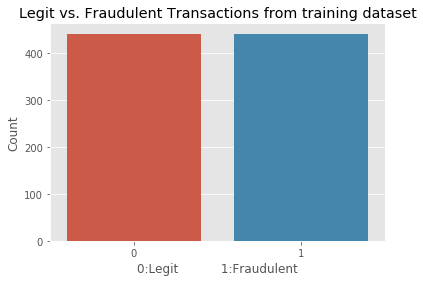

In [ ]:
#Check how many legit and Fraudulent transactions we have

count = finalTrain.Class.value_counts()
sns.barplot(x=count.index, y=count)
plt.title('Legit vs. Fraudulent Transactions from training dataset')
plt.ylabel('Count')
plt.xlabel('0:Legit           1:Fraudulent')

In [ ]:
#Could be double checking the correlations

In [ ]:
#Removing extreme outliers
initialLength = len(finalTrain)

Q1 = finalTrain.quantile(0.25)
Q3 = finalTrain.quantile(0.75)
IQR = Q3 - Q1

finalTrain = finalTrain[~((finalTrain < (Q1 - 2.5 * IQR)) |(finalTrain > (Q3 + 2.5 * IQR))).any(axis=1)]

finalLength = len(finalTrain)
difference  = initialLength - finalLength

print('initial size {} reduced by {} transactions to {} transactions.'.format(initialLength, difference, finalLength))

initial size 882 reduced by 267 transactions to 615 transactions.


In [ ]:
#4-  Dimension reduction to help visualize the dataset on a 2d space
from sklearn.manifold import TSNE
# the training dataset without the column we want to target
X = finalTrain.drop('Class', axis=1)
# the target prediction column
y = finalTrain['Class']

In [ ]:
#t-SNE
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

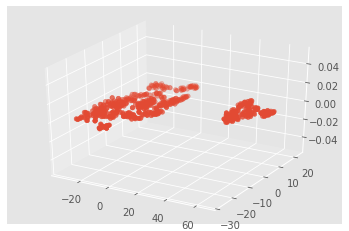

In [ ]:
# t-SNE 3D visualisation of the training dataset
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*zip(*X_reduced_tsne))

plt.show()

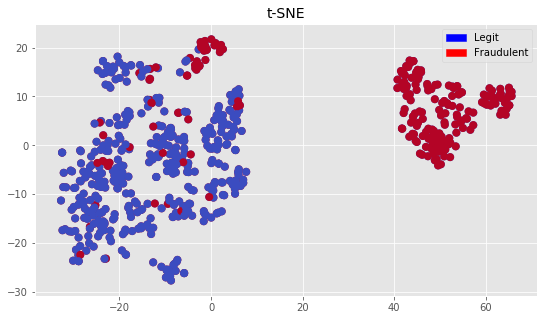

In [ ]:
# t-SNE 2D visualisation of the training dataset
import matplotlib.patches as mpatches
f, ax = plt.subplots(figsize=(9,5))

legit_patch = mpatches.Patch(color='blue', label='Legit')
fraud_patch = mpatches.Patch(color='red', label='Fraudulent')

ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Legit', linewidths=2)
ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraudulent', linewidths=2)
ax.set_title('t-SNE', fontsize=14)

ax.grid(True)
ax.legend(handles=[legit_patch, fraud_patch])


In [ ]:
#5- Prepare Training, testing dataset, Build, Check models and fit the best one with de training dataset

In [ ]:
#Spliting the datasets in training and test datasets  using SciKitlearn train_test_split preparation function
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
X_train = X_train.values
X_validation = X_test.values
y_train = y_train.values
y_validation = y_test.values

In [ ]:
print('X_shapes:\n', 'X_train:', 'X_validation:\n', X_train.shape, X_validation.shape, '\n')
print('Y_shapes:\n', 'Y_train:', 'Y_validation:\n', y_train.shape, y_validation.shape)

X_shapes:
 X_train: X_validation:
 (553, 30) (62, 30) 

Y_shapes:
 Y_train: Y_validation:
 (553,) (62,)


In [ ]:
#Import validation functions and classification models from library
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier


In [ ]:
#Finding the best model for our classification problem
# by using the cross_val_score with the roc_auc as the initial dataset have unbalancy class representation (fewer Fraudulent transaction compared to legit ones)

#Ignore the warnings to have a greater visibility in console
def warn(*args, **kwargs):
    pass
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.warn = warn


#Instanciate the models
models = []
models.append(('sk_LR', LogisticRegression()))
models.append(('sk_LDA', LinearDiscriminantAnalysis()))
models.append(('sk_KNN', KNeighborsClassifier()))
models.append(('sk_CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('XGB', XGBClassifier()))
models.append(('RF', RandomForestClassifier()))

#instanciates placeholders for the different models
results = []
names = []

#iterates on each models to check the model using the cross_val_score function
for name, model in models:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    #msg = '%s model : {:.2f} % accuracy,  (%f)' % (name, cv_results.mean()*100, cv_results.std())
    msg = '{}: {:.2f} % accuracy,  ({:.4f} std)'.format(name, cv_results.mean()*100, cv_results.std())

    print(msg)

#print('There were {} non-fraudulent transactions {:.3f}% and {} fraudulent transactions {:.3f}%.'.format(normal, perc_normal, fraudulent, perc_fraudulent))


sk_LR: 97.69 % accuracy,  (0.0197 std)
sk_LDA: 97.48 % accuracy,  (0.0204 std)
sk_KNN: 95.24 % accuracy,  (0.0268 std)
sk_CART: 90.71 % accuracy,  (0.0326 std)
SVM: 96.76 % accuracy,  (0.0236 std)
XGB: 97.39 % accuracy,  (0.0155 std)
RF: 96.82 % accuracy,  (0.0206 std)


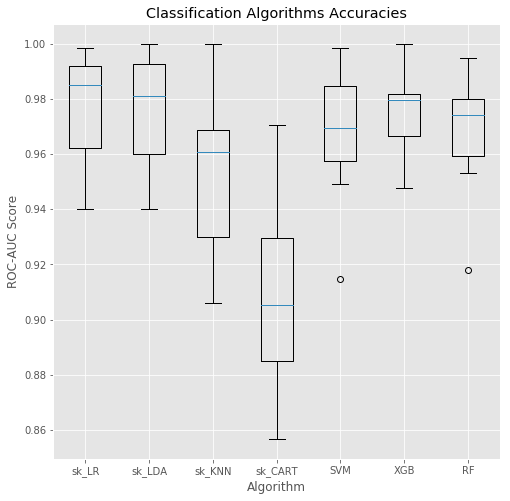

In [ ]:
#Compare Algorithms
fig = plt.figure(figsize=(8,8))
plt.title('Classification Algorithms Accuracies')
plt.xlabel('Algorithm')
plt.ylabel('ROC-AUC Score')
plt.boxplot(results)
ax = fig.add_subplot(111)
ax.set_xticklabels(names)

plt.show()

In [ ]:
#Working with XgBoost Classifier
XGB = XGBClassifier()

#Model training
XGB.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
# Prediction, using XGB.predict( transaction_data)

# Here as the new data we want to predict fraudulent or legit transaction we would generate a transaction data by shuffling the original dataset to generate a randomized transaction
testTransactionBuilder = data.drop('Class', axis=1)
LineCount = testTransactionBuilder.V1.count()
for column in testTransactionBuilder:
    testTransactionBuilder[column] = np.random.permutation(testTransactionBuilder[column].values)
a = random.randint(0,LineCount)
Testtxn = testTransactionBuilder.iloc[a]
Testtxn = Testtxn.values
#Xgboost expects 2D data for prediction, to predict only one sample we have to reshape our test transaction feature vector to a 2D
TesttxnXGB = np.array(Testtxn).reshape((1,-1))

#Model prediction on new data
predict = XGB.predict(TesttxnXGB)

#The predict result is the predicted Class 0 for legit transaction and 1
if predict[0] == 0:
    print("Legit transaction, transaction data : {} ".format(TesttxnXGB) )
if predict[0] == 1:
    print("Fraudulent transaction, transaction data: {} ".format(TesttxnXGB))



Legit transaction, transaction data : [[ 1.27986073 -1.32356745  2.11767884  1.39556698 -1.58863095 -0.52702338
  -1.18971381 -0.25322921 -0.36111394 -0.94434893 -0.57571758  0.42843476
   0.28495301  0.32916006  0.90542365 -1.41299776 -0.58361778 -0.226682
  -0.59831912  0.02795851 -1.75983854 -0.63785823  0.01010716 -0.46488836
   0.54987939  0.14303045 -0.68653178  0.19282292 -0.25331722 -0.32513139]] 


In [ ]:
#Bonus :: Find a Fraudulent transaction by doing a Loop
while predict[0] == 0:
  for column in testTransactionBuilder:
      testTransactionBuilder[column] = np.random.permutation(testTransactionBuilder[column].values)
  a = random.randint(0,LineCount)
  Testtxn = testTransactionBuilder.iloc[a]
  Testtxn = Testtxn.values
  # xgboost expects 2D data for prediction, to predict only one sample we have to reshape our test transaction feature vector to a 2D
  TesttxnXGB = np.array(Testtxn).reshape((1,-1))
  predict = XGB.predict(TesttxnXGB)
#the predict result is the predicted Class 0 for legit transaction and 1
if predict[0] == 0:
    print("Legit transaction: {} ".format(TesttxnXGB) )
if predict[0] == 1:
    print("Fraudulent transaction: {} ".format(TesttxnXGB))

Fraudulent transaction: [[ 1.122298   -0.75852537 -1.01639027 -0.53770864 -0.88203566  1.3285049
  -1.05127419 -0.15192432  0.70715225 -0.70900273 -0.2867509   0.24239081
  -1.03800415 -3.6600857  -0.80967287 -0.58139265 -0.9653649   1.55609413
   0.25337597 -0.13489708 -0.17796487  0.97918657 -0.53775604 -0.56726393
   0.32844274 -0.01194113  0.04839564  0.01129521  1.20002709  1.51419402]] 
